### Import Libraries


In [1]:
!pip install -U tensorflow==2.14.0

  Obtaining dependency information for tensorflow==2.14.0 from https://files.pythonhosted.org/packages/e2/7a/c7762c698fb1ac41a7e3afee51dc72aa3ec74ae8d2f57ce19a9cded3a4af/tensorflow-2.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packages/d1/1d/d5cf76e5e40f69dbd273036e3172ae4a614577cb141673427b80cac948df/ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.6 MB/s eta 0:00:00
  Obtaining dependency information for tensorboard<2.15,>=2.14 from https://files.pythonhosted.org/packages/73/a2/66ed644f6ed1562e0285fcd959af17670ea313c8f331c46f79ee77187eb9/tensorboard-2.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-estimator<2.15,>=2.14.0 from https://files.pythonhosted.org/packages/d1/da/4f264c196325bb6e37a6285caec5b12a03def489b57cc1fdac02bb6272cd/tensor

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.convnext import preprocess_input
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
###
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

2.14.0


In [3]:
# Import some other useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#dataset_dir = np.load('public_data.npz',allow_pickle=True)
dataset_dir = np.load('/kaggle/input/public-data-npz/public_data.npz',allow_pickle=True) #For Kaggle
# Access the keys
lst = dataset_dir.files
images = dataset_dir['data']
labels = dataset_dir['labels']

# Convert values in data to int
images = images.astype(int)

---
### Clean DataSet( not necessary if you download the dataset directly from GitHub)
---

In [5]:
# Save bad images
shrek = images[58]
trololo = images[338]

In [6]:
# Create the mask for bad images
shrek_mask = np.all(images == shrek, axis=(1, 2, 3))
unique_shrek, count_shrek = np.unique(shrek_mask, return_counts= True)
print("There are ", count_shrek[1], " shrek images")

trololo_mask = np.all(images == trololo, axis=(1, 2, 3))
unique_trololo, count_trololo = np.unique(trololo_mask, return_counts= True)
print("and ", count_trololo[1], " trololo images.")

mask_bad = np.logical_or(shrek_mask, trololo_mask)

There are  98  shrek images
and  98  trololo images.


In [7]:
# Delete bad images
images_leaves = images[np.logical_not(mask_bad)]
labels_leaves = labels[np.logical_not(mask_bad)]
print("There are ", len(images_leaves), " leaves images.")

There are  5004  leaves images.


In [8]:
# Find unique images
unique_images, indices_unique_images, count_unique_images = np.unique(images_leaves, return_index= True, return_counts= True, axis= 0)
print("There are ",len(count_unique_images), " unique images.")
images_unique = images_leaves[indices_unique_images]
labels_unique = labels_leaves[indices_unique_images]

There are  4850  unique images.


In [9]:
# Release memory
#del data
del images
del labels
del images_leaves
del labels_leaves

In [10]:


uniques, count = np.unique(labels_unique, return_counts= True)
N_HEALTHY = count[0]
N_UNHEALTHY = count[1]
N_SAMPLES = N_HEALTHY + N_UNHEALTHY

print("The dataset contains:")
print(N_HEALTHY, " healthy samples")
print(N_UNHEALTHY, " unhealthy samples")
print("For a total of ", N_SAMPLES, " samples")



The dataset contains:
3060  healthy samples
1790  unhealthy samples
For a total of  4850  samples


In [11]:
# Extract the 'unhealthy' images
unhealthy_data = images_unique[labels_unique == 'unhealthy']
unhealthy_labels = labels_unique[labels_unique == 'unhealthy']
unhealthy_data.shape

(1790, 96, 96, 3)

In [12]:
# Compute the ratio between healthy/unhealthy
DIFF = N_HEALTHY-N_UNHEALTHY
DIFF

1270

In [13]:
# Increase the number of unhealthy by rotating images
from tensorflow.image import rot90

new_unhealthy_data = np.empty((0, 96, 96, 3))

for i in range(DIFF):
    image_idx = random.randint(0, N_UNHEALTHY-1)
    rotation_angle = tf.random.uniform(shape=[], minval=-45, maxval=45, dtype=tf.float32)
    rotated_image = rot90(unhealthy_data[image_idx], k=tf.cast(rotation_angle / 45, dtype=tf.int32))
    rotated_image = tf.expand_dims(rotated_image, axis=0)
    new_unhealthy_data = tf.concat([new_unhealthy_data, rotated_image], axis=0)

In [14]:
# Add label for new unhealthy images
new_unhealthy_labels = np.array(['unhealthy'] * (DIFF))

In [15]:
# Add new images to dataset
X = tf.concat([unique_images, new_unhealthy_data], axis=0)
y = tf.concat([labels_unique, new_unhealthy_labels], axis=0)

# Shuffle the data
idxs = np.array(range(len(y)))
random.shuffle(idxs)

X = np.array(tf.gather(X, idxs))
y = np.array(tf.gather(y, idxs))

In [16]:
del unhealthy_data
del unhealthy_labels
del new_unhealthy_data, new_unhealthy_labels

### Create train and validation sets

In [17]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label.decode()] for label in y])

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)


# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

del X_train_val, y_train_val

---
### Data Pre-Processing like MoblieNetV2
---

In this section, we introduce a distinctive approach to data augmentation, deviating from the conventional use of the augmentation layer from the TensorFlow Keras library. Instead, we have implemented a custom data augmentation pipeline utilizing the ImageDataGenerator with two distinct folders dedicated to the training set and the validation set.

Gaussian Noise Addition

To inject variability into the training dataset, we have implemented a custom class for adding random Gaussian noise to input images. This stochastic process introduces subtle variations in pixel values, promoting a more robust learning experience for the model. The randomness of the noise aids in simulating real-world scenarios where images may exhibit imperceptible fluctuations.

Geometric Augmentation with Crop

Complementing the Gaussian noise addition, we have devised a class that incorporates a sequence of geometric augmentations centered around cropping. This sequence includes operations such as rotation, scaling, and flipping, resulting in diverse perspectives of the input images. The crop operation, in particular, introduces variability in spatial composition, challenging the model to generalize effectively.

In [29]:
import numpy as np
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.layers import Layer

def random_erasing(img):
    p = 0.3  # Probability of applying the erasing operation
    s_l = 0.02  # Minimum area of the erased rectangle relative to the total area of the image
    s_h = 0.4  # Maximum area of the erased rectangle relative to the total area of the image
    r_1 = 0.3  # Minimum length/width ratio of the erased rectangle
    r_2 = 1 / r_1  # Maximum length/width ratio of the erased rectangle

    if np.random.rand() < p:
        img_area = img.shape[0] * img.shape[1]

        target_area = np.random.uniform(s_l, s_h) * img_area
        aspect_ratio = np.random.uniform(r_1, r_2)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))

        if w < img.shape[1] and h < img.shape[0]:
            x = np.random.randint(0, img.shape[0] - h + 1)
            y = np.random.randint(0, img.shape[1] - w + 1)
            img[x:x+h, y:y+w, :] = np.random.uniform(0, 255, (h, w, img.shape[2]))

    return img

# Preprocessing function that applies Random Erasing, Gaussian Noise, and the preprocessing of MobileNetV2
def preprocess_image(image):
    # Apply Random Erasing
    image = random_erasing(image)

    # Add Gaussian Noise with a probability of 0.3 (you can adjust the probability)
    if np.random.rand() < 0.3:
        noise = np.random.normal(loc=0, scale=9, size=image.shape)
        image = image + noise

    # Apply ConNeXtTiny preprocessing
    image = preprocess_input(image)

    return image


In [28]:
home_path = '/kaggle/input/train-dataset' #For Kaggle
home_path_valid = '/kaggle/input/valid-set'
training_dir = os.path.join(home_path, 'train')
validation_dir = os.path.join(home_path_valid, 'valid')

valid_data_gen = ImageDataGenerator( preprocessing_function=preprocess_input)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,#32
                                               shuffle=True,
                                               seed=seed)

Found 612 images belonging to 2 classes.


In [30]:
aug_train_data_gen = ImageDataGenerator(
                                        rotation_range = 45,
                                        shear_range=0.2,
                                        width_shift_range = 0.2,
                                        zoom_range=[0.5,1.4],
                                        vertical_flip = True,
                                        horizontal_flip = True,
                                        brightness_range=[0.8, 1.7],
                                        fill_mode='reflect',
                                        preprocessing_function=preprocess_image
                                        )
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,#32
                                                       shuffle=True,
                                                       seed=seed)

Found 5508 images belonging to 2 classes.


In [31]:
convnext = tf.keras.applications.ConvNeXtTiny(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
    #pooling='avg',
    classes=2,
    classifier_activation='softmax',
)
convnext.trainable = False

The architecture incorporates the Swish Activation Layer alongside the ReLU activation layer to mitigate the issue of decaying neurons

In [32]:
import keras_cv.layers as kcvl
def build_convnext_with_augmentation(input_shape=(96, 96, 3)):
    tf.random.set_seed(seed)
    
    inputs = tfk.Input(shape=input_shape)
    #augmentation = img_augmentation(inputs)
    #augmented_255 = tf.cast(augmentation* 255, tf.uint8)
    
    #x1 = convnext(augmented_255)
    x1 = convnext(inputs)

    x2 = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    x3 = tfkl.BatchNormalization()(x2)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    intermediate1 = tfkl.Dense(64, activation=tf.keras.activations.swish)(x3)
    intermediate2 = tfkl.Dense(128, activation=tf.keras.activations.swish)(intermediate1)
    intermediate3 = tfkl.Dense(256, activation=tf.keras.activations.swish)(intermediate2)
    intermediate4 = tfkl.Dense(512, activation=tf.keras.activations.swish)(intermediate3)
    intermediate5 = tfkl.Dense(256, activation=tf.keras.activations.swish)(intermediate4)
    intermediate6 = tfkl.Dense(64, activation=tf.keras.activations.swish)(intermediate5)
    intermediate7 = tfkl.Dense(32, activation=tf.keras.activations.swish)(intermediate6)
    intermediate8 = tfkl.Dense(8, activation=tf.keras.activations.swish)(intermediate7)
    
    outputs = tfkl.Dense(2, activation='softmax')(intermediate8)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    #optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    #optimizer=tfk.optimizers.experimental.SGD(learning_rate=0.001,momentum=0.9)
    optimizer=tfk.optimizers.Lion(learning_rate=0.0001)
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    # Return the model
    return model

In [33]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 15:
        return lr  
    else:
        return lr * tf.math.exp(-0.1)  
    
lr_schedule = LearningRateScheduler(lr_scheduler)

In [34]:
tl_model = build_convnext_with_augmentation()

tl_history = tl_model.fit(
    aug_train_gen,
    epochs=100,
    validation_data= valid_gen,
    verbose = 1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True) , lr_schedule ]
).history

Epoch 1/100
173/173 [==============================] - 47s 200ms/step - loss: 0.6046 - accuracy: 0.6716 - val_loss: 0.5517 - val_accuracy: 0.7190 - lr: 1.0000e-04
Epoch 2/100
173/173 [==============================] - 29s 167ms/step - loss: 0.5043 - accuracy: 0.7484 - val_loss: 0.5567 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 3/100
173/173 [==============================] - 29s 166ms/step - loss: 0.4665 - accuracy: 0.7752 - val_loss: 0.4803 - val_accuracy: 0.7549 - lr: 1.0000e-04
Epoch 4/100
173/173 [==============================] - 29s 168ms/step - loss: 0.4468 - accuracy: 0.7901 - val_loss: 0.4303 - val_accuracy: 0.7810 - lr: 1.0000e-04
Epoch 5/100
173/173 [==============================] - 29s 168ms/step - loss: 0.4363 - accuracy: 0.7928 - val_loss: 0.4519 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 6/100
173/173 [==============================] - 29s 168ms/step - loss: 0.4294 - accuracy: 0.7961 - val_loss: 0.4402 - val_accuracy: 0.7663 - lr: 1.0000e-04
Epoch 7/100
173/173 [=

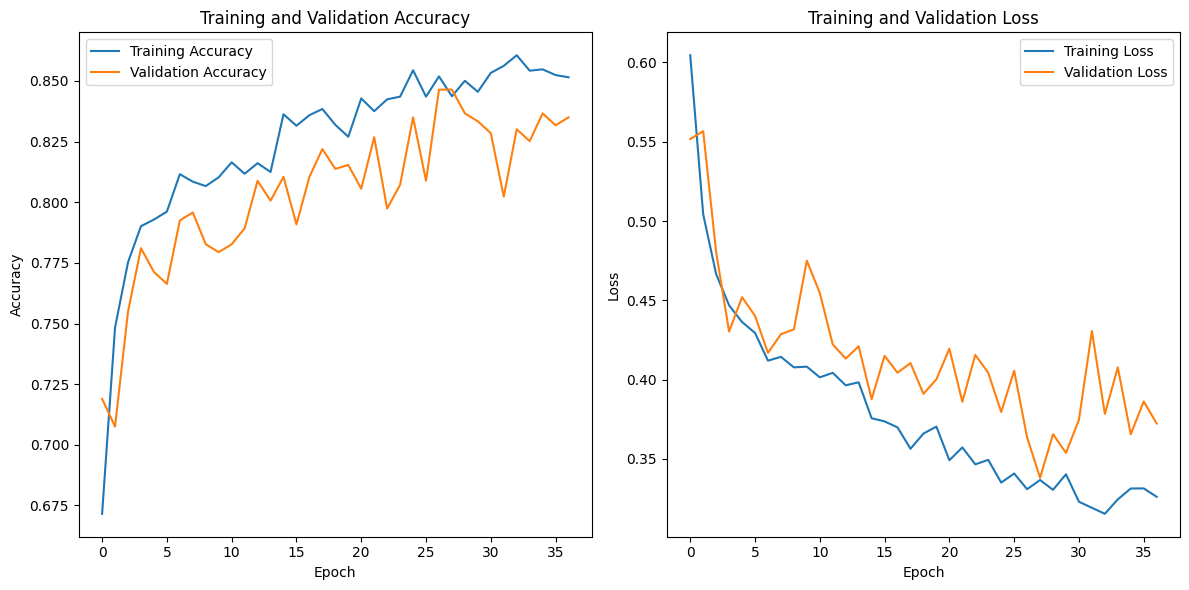

In [35]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history['accuracy'], label='Training Accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(tl_history['loss'], label='Training Loss')
plt.plot(tl_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import shutil
shutil.rmtree("/kaggle/working/convnext_TL2")


In [ ]:
shutil.rmtree("/kaggle/working/convnext_FTall2")

In [36]:
model_name = 'convnext_TL2'
print("Finished training of", model_name, "model")
tl_model.save(model_name, save_format='tf')

Finished training of convnext_TL2 model


In [ ]:
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

best_val_accuracy = last_val_accuracy
best_model = model_name

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

# Fine Tuning - all

In [37]:
# Set all layers as trainable
tl_model.trainable = True

if all(layer.trainable for layer in tl_model.layers):
    print("Successful!")
else:
    print("Error!")

Successful!


In [38]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr  
    else:
        return lr * tf.math.exp(-0.1) 

In [39]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(), metrics='accuracy')

lr_schedule = LearningRateScheduler(lr_scheduler)

In [40]:
# Train the model
print("All layers are training.")
tl_history = tl_model.fit_generator(
    aug_train_gen,
    epochs=200,
    validation_data= valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True) , lr_schedule ]
).history

All layers are training.
Epoch 1/200
173/173 [==============================] - 67s 214ms/step - loss: 0.4041 - accuracy: 0.8163 - val_loss: 0.4785 - val_accuracy: 0.7582 - lr: 1.0000e-04
Epoch 2/200
173/173 [==============================] - 32s 186ms/step - loss: 0.3816 - accuracy: 0.8264 - val_loss: 0.4785 - val_accuracy: 0.8203 - lr: 1.0000e-04
Epoch 3/200
173/173 [==============================] - 32s 184ms/step - loss: 0.3496 - accuracy: 0.8466 - val_loss: 0.4239 - val_accuracy: 0.8301 - lr: 1.0000e-04
Epoch 4/200
173/173 [==============================] - 33s 188ms/step - loss: 0.3355 - accuracy: 0.8533 - val_loss: 0.3729 - val_accuracy: 0.8268 - lr: 1.0000e-04
Epoch 5/200
173/173 [==============================] - 32s 185ms/step - loss: 0.2917 - accuracy: 0.8813 - val_loss: 0.3218 - val_accuracy: 0.8497 - lr: 1.0000e-04
Epoch 6/200
173/173 [==============================] - 32s 185ms/step - loss: 0.2928 - accuracy: 0.8725 - val_loss: 0.3298 - val_accuracy: 0.8660 - lr: 1.0000e-

---
### Fine-Tuning By Tommy
---

In [ ]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-5), metrics=['accuracy'])

In [ ]:
# Train the model
print("All layers are training.")
tl_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 20,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=250, restore_best_weights=True)]
).history

---

In [44]:
model_name = 'convnext_FTall2'
print("Finished training of ", model_name, " model")
tl_model.save(model_name, save_format = 'tf')

Finished training of  convnext_FTall2  model


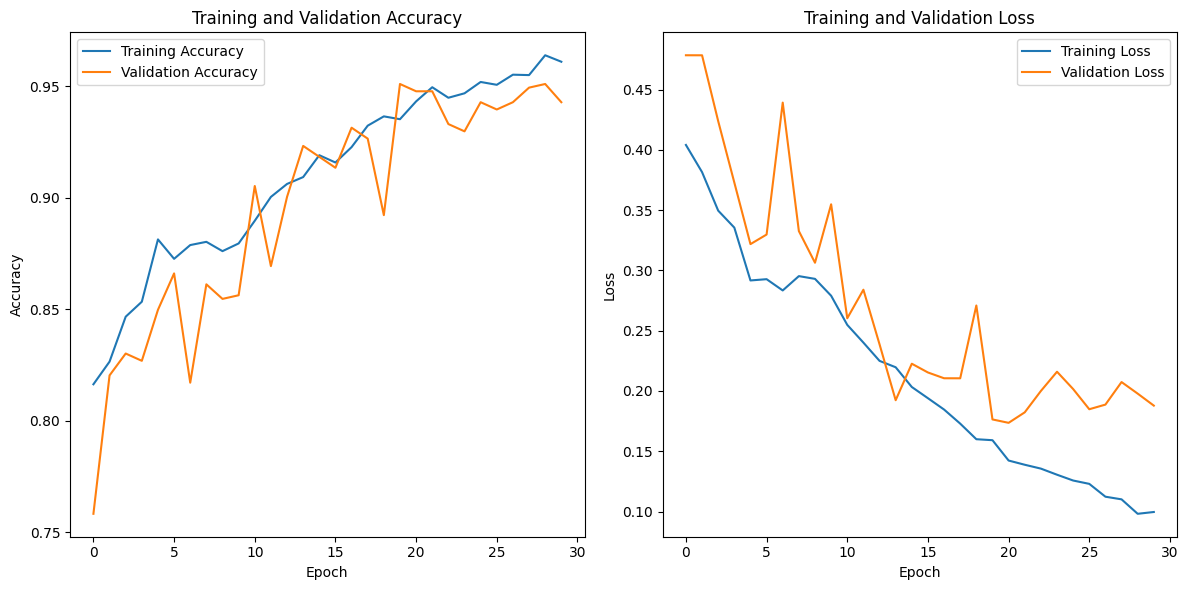

In [41]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history['accuracy'], label='Training Accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(tl_history['loss'], label='Training Loss')
plt.plot(tl_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Predict labels for the entire test set
predictions = tl_model.predict(preprocess_input(X_val*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

print(predictions)

Predictions Shape: (612, 2)
[[9.9998915e-01 1.0859608e-05]
 [2.1778185e-04 9.9978226e-01]
 [3.9557364e-02 9.6044266e-01]
 ...
 [5.3725846e-04 9.9946278e-01]
 [9.7741419e-03 9.9022585e-01]
 [9.9983764e-01 1.6237076e-04]]


In [ ]:
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

Accuracy: 0.9575
Precision: 0.9575
Recall: 0.9575
F1: 0.9575


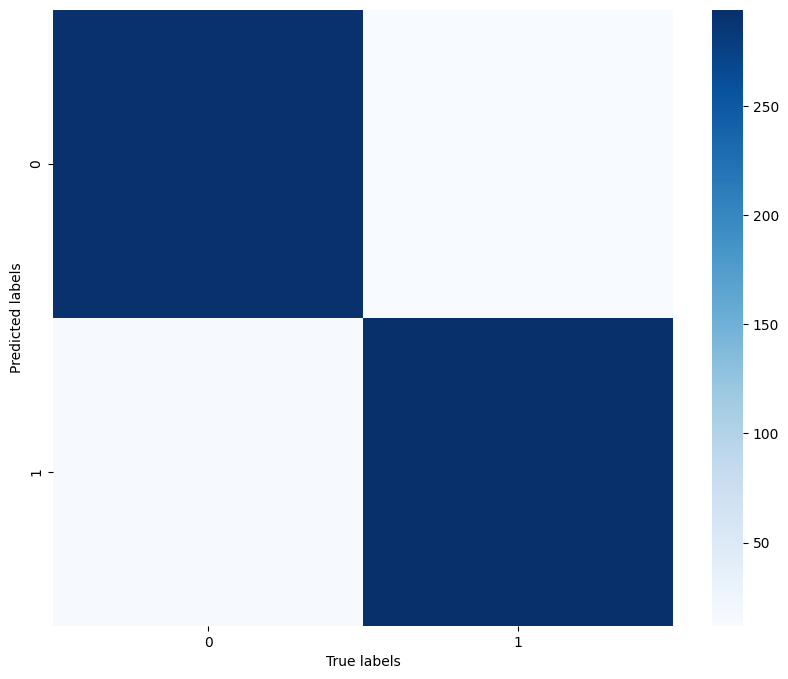

In [43]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
del tl_model

In [ ]:
if best_val_accuracy <= last_val_accuracy: # current model is better than the previous one
    best_val_accuracy = last_val_accuracy
    best_model = model_name
else: 
    print("No improvement with current model...")
    print("Best model is still ", best_model, ": reloading it!")
    tl_model = tfk.models.load_model(best_model)

In [ ]:
print("Saving best model")
tl_model.save('best')

In [ ]:
best_val_loss, best_val_accuracy = tl_model.evaluate(X_val, y_val)
best_train_loss, best_train_accuracy = tl_model.evaluate(X_train, y_train)
best_model_data = np.array([[best_val_loss, best_val_accuracy, best_train_loss, best_train_accuracy]])

# Output history

In [ ]:
data = np.array([val_loss, val_accuracy, train_loss, train_accuracy])
best_model_data = np.array(best_model_data)

# Transpose the array so that each metric is in a separate row
data = data.T

# Define the header for the columns
header = "val_loss\tval_accuracy\ttrain_loss\ttrain_accuracy"

# Save the data to a text file
np.savetxt('output.txt', data, header=header, comments='', delimiter='\t')

# Append a separator line
with open('output.txt', 'a') as file:
    file.write('\n' + '-'*40 + '\n')

# Append the "Best model" section
np.savetxt('output.txt', best_model_data, header="Best model:", comments='', delimiter='\t', fmt='%s', footer='\n')

# Train also on validation set

In [ ]:
# Load best model
tl_model = tfk.models.load_model(best_model)

In [ ]:
# Set all layers as trainable
tl_model.trainable = True

if all(layer.trainable for layer in tl_model.layers):
    print("Successful!")
else:
    print("Error!")

In [ ]:
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-6), metrics=['accuracy'])

In [ ]:
# Train the model
print("All layers are training.")
tl_history = tl_model.fit(
    x = X_val, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_val,
    batch_size = 16,
    epochs = 400,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=120, restore_best_weights=True)]
).history

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(tl_history['accuracy'], label='Training Accuracy')
plt.plot(tl_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(tl_history['loss'], label='Training Loss')
plt.plot(tl_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_name = 'convnext_FTval'
print("Finished training of ", model_name, " model")
tl_model.save(model_name)

In [ ]:
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)

In [ ]:
if best_val_accuracy <= last_val_accuracy: # current model is better than the previous one
    print("Better performance with training on validation set! ")
else: 
    print("No improvement with training model on validation set...")
    print("Best model is still ", best_model)

In [ ]:
val_model_data = np.array([[last_val_loss, last_val_accuracy]])
with open('output.txt', 'a') as file:
    file.write('\n' + '-'*40 + '\n')

# Append the "Best model" section
np.savetxt('output.txt', val_model_data, header="Model trained on validation:", comments='', delimiter='\t', fmt='%s', footer='\n')